In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

In [ ]:
SEED = 42
np.random.seed(SEED)

# 1. Prétraitement des Données

In [ ]:
def get_metadata(root: str) -> pd.DataFrame:
    metadata = {"path": [], "label": []}
    for label in os.listdir(root):
        label_dir = os.path.join(root, label)
        if os.path.isdir(label_dir):
            for img in os.listdir(label_dir):
                metadata["path"].append(os.path.join(label_dir, img))
                metadata["label"].append(label)
    return pd.DataFrame(metadata)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/UC_Merced_Land_Use/UCMerced_LandUse/Images'

In [ ]:
metadata = get_metadata(DATA_DIR)
print(f"Dataset contains {len(metadata)} images across {metadata['label'].nunique()} categories.")
print(metadata.head())

Dataset contains 2110 images across 21 categories.
                                                path             label
0  /content/drive/MyDrive/UC_Merced_Land_Use/UCMe...  denseresidential
1  /content/drive/MyDrive/UC_Merced_Land_Use/UCMe...  denseresidential
2  /content/drive/MyDrive/UC_Merced_Land_Use/UCMe...  denseresidential
3  /content/drive/MyDrive/UC_Merced_Land_Use/UCMe...  denseresidential
4  /content/drive/MyDrive/UC_Merced_Land_Use/UCMe...  denseresidential


# 3. Visualize Sample Image


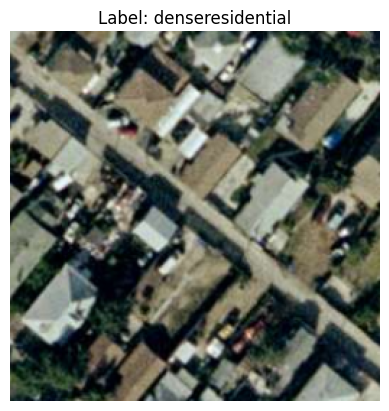

In [ ]:
sample = metadata.iloc[0]
img = cv2.imread(sample['path'])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title(f"Label: {sample['label']}")
plt.axis("off")
plt.show()

# Step 2: Feature Extraction with SIFT

In [ ]:
def extract_sift_features(metadata: pd.DataFrame) -> dict:
    sift = cv2.SIFT_create()
    features = {}
    for i, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting SIFT Features"):
        img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            kp, des = sift.detectAndCompute(img, None)
            features[row['path']] = {'features': des, 'label': row['label']}
    return features

In [ ]:
sift_features = extract_sift_features(metadata)
print(f"Extracted features from {len(sift_features)} images.")

Extracting SIFT Features:   0%|          | 0/2110 [00:00<?, ?it/s]

Extracted features from 2110 images.


In [ ]:
example_key = list(sift_features.keys())[0]
example_features = sift_features[example_key]['features']
print(f"Example features shape: {example_features.shape}")
print(f"Label: {sift_features[example_key]['label']}")

Example features shape: (1115, 128)
Label: denseresidential


### Step 3: Data Splitting

In [ ]:
def split_dataset(data_dict: dict, test_ratio: float = 0.2):
    paths = list(data_dict.keys())
    labels = [data_dict[path]['label'] for path in paths]
    train_paths, test_paths = train_test_split(
        paths,
        test_size=test_ratio,
        stratify=labels,
        random_state=SEED
    )
    train_data = {path: data_dict[path] for path in train_paths}
    test_data = {path: data_dict[path] for path in test_paths}
    return train_data, test_data

In [ ]:
train_data, test_data = split_dataset(sift_features)
print(f"Training set size: {len(train_data)}, Test set size: {len(test_data)}")

Training set size: 1688, Test set size: 422


### Step 4: Mean Aggregation (new names)

In [ ]:
def aggregate_by_mean(data: dict) -> dict:
    return {
        path: {
            'features': np.mean(info['features'], axis=0) if info['features'] is not None else None,
            'label': info['label']
        }
        for path, info in data.items()
    }

mean_train_data = aggregate_by_mean(train_data)
mean_test_data = aggregate_by_mean(test_data)

In [ ]:
mean_example = list(mean_train_data.values())[0]
print(f"Mean aggregated features: {mean_example['features'].shape}")
print(f"Corresponding label: {mean_example['label']}")

Mean aggregated features: (128,)
Corresponding label: freeway


### Step 5: VBOW

In [ ]:
class VisualBagOfWords:
    def __init__(self, num_clusters=100, norm=2):
        self.kmeans_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kmeans', MiniBatchKMeans(n_clusters=num_clusters, random_state=SEED))
        ])
        self.num_clusters = num_clusters
        self.norm = norm

    def fit(self, data: dict):
        all_features = np.vstack(
            [info['features'] for info in data.values() if info['features'] is not None]
        )
        self.kmeans_pipeline.fit(all_features)
        return self

    def transform_sample(self, features: np.ndarray) -> np.ndarray:
        if features is None:
            return np.zeros(self.num_clusters)
        cluster_indices = self.kmeans_pipeline.predict(features)
        histogram = np.bincount(cluster_indices, minlength=self.num_clusters)
        return histogram / np.linalg.norm(histogram, ord=self.norm)

    def transform(self, data: dict) -> dict:
        return {
            path: {
                'features': self.transform_sample(info['features']),
                'label': info['label']
            }
            for path, info in data.items()
            }
vbow = VisualBagOfWords(num_clusters=100).fit(train_data)
vbow_train_data = vbow.transform(train_data)
vbow_test_data = vbow.transform(test_data)

In [ ]:
vbow_example = list(vbow_train_data.values())[0]
print(f"VBOW features: {vbow_example['features'].shape}")
print(f"Corresponding label: {vbow_example['label']}")

VBOW features: (100,)
Corresponding label: freeway


### Step 6: Model Training and Evaluation (new names)

In [ ]:
def train_and_evaluate_model(train_data, test_data):
    X_train = np.array([info['features'] for info in train_data.values() if info['features'] is not None])
    y_train = np.array([info['label'] for info in train_data.values() if info['features'] is not None])
    X_test = np.array([info['features'] for info in test_data.values() if info['features'] is not None])
    y_test = np.array([info['label'] for info in test_data.values() if info['features'] is not None])

    model = Pipeline([('scaler', StandardScaler()), ('classifier', SVC())])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    print(classification_report(y_test, predictions))
    return classification_report(y_test, predictions, output_dict=True)

In [ ]:
# Evaluate Mean Aggregation
print("=== Classification Report (Mean Aggregation) ===")
mean_report = train_and_evaluate_model(mean_train_data, mean_test_data)


=== Classification Report (Mean Aggregation) ===
                   precision    recall  f1-score   support

     agricultural       0.89      0.94      0.92        18
         airplane       0.74      0.70      0.72        20
  baseballdiamond       0.50      0.35      0.41        20
            beach       0.84      0.80      0.82        20
        buildings       0.42      0.65      0.51        20
        chaparral       1.00      1.00      1.00        20
 denseresidential       0.45      0.50      0.48        20
           forest       0.77      1.00      0.87        20
          freeway       0.71      0.50      0.59        20
       golfcourse       0.68      0.75      0.71        20
           harbor       0.95      0.90      0.92        20
     intersection       0.43      0.60      0.50        20
mediumresidential       0.53      0.36      0.43        22
   mobilehomepark       0.62      0.80      0.70        20
         overpass       0.60      0.75      0.67        20
      

In [ ]:
# Evaluate VBOW Aggregation
print("=== Classification Report (VBOW Aggregation) ===")
vbow_report = train_and_evaluate_model(vbow_train_data, vbow_test_data)

=== Classification Report (VBOW Aggregation) ===
                   precision    recall  f1-score   support

     agricultural       0.95      0.95      0.95        20
         airplane       0.89      0.85      0.87        20
  baseballdiamond       0.59      0.50      0.54        20
            beach       0.75      0.90      0.82        20
        buildings       0.41      0.55      0.47        20
        chaparral       1.00      0.95      0.97        20
 denseresidential       0.46      0.55      0.50        20
           forest       0.83      1.00      0.91        20
          freeway       0.67      0.50      0.57        20
       golfcourse       0.58      0.70      0.64        20
           harbor       1.00      1.00      1.00        20
     intersection       0.58      0.55      0.56        20
mediumresidential       0.53      0.41      0.46        22
   mobilehomepark       0.74      0.85      0.79        20
         overpass       0.45      0.65      0.53        20
      